In [246]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [247]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Question 2: Classification Using CNN

### Data Loading and Preprocessing

In [248]:
def load_mnist_data(path):
    splits = ['train', 'val', 'test']
    data = {'train': [], 'val': [], 'test': []}
    labels = {'train': [], 'val': [], 'test': []}
    for split in splits:
        split_path = os.path.join(path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if (len(label)==1 and int(label) == 0):
                cur_label = 0
            else:
                cur_label = len(label)
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    try:
                        image = Image.open(image_path).convert('L')
                        image_array = np.array(image)
                        data[split].append(image_array)
                        labels[split].append(cur_label)
                    except Exception as e:
                        print(f"Error loading image {image_name}: {e}")
    
    return data['train'], labels['train'], data['val'], labels['val'], data['test'], labels['test']



In [249]:
data_path = "./../../data/external/double_mnist"

train_data, train_labels, val_data, val_labels, test_data, test_labels = load_mnist_data(data_path)

In [250]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, task = 'classification', transform=None):
        self.images = images
        self.labels = labels
        self.task = task
        self.transform = transform
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)
            
        if (self.task == 'classification'):
            label = torch.tensor(label, dtype=torch.long).to(device)
        elif (self.task == 'regression'):
            label = torch.tensor(label, dtype=torch.float32).to(device).unsqueeze(0)
        return image, label


### Implement the CNN Class

In [251]:
class CNN(nn.Module):
    def __init__(self, task='classification', num_classes=10):
        super(CNN, self).__init__()
        
        self.task = task
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        
        if task == 'classification':
            self.fc3 = nn.Linear(64, num_classes)
        elif task == 'regression':
            self.fc3 = nn.Linear(64, 1)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output, _ = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        feature_maps = {}
        x = self.pool(self.relu(self.conv1(x)))
        feature_maps['conv1'] = x
        x = self.pool(self.relu(self.conv2(x)))
        feature_maps['conv2'] = x
        x = self.pool(self.relu(self.conv3(x)))
        feature_maps['conv3'] = x
        return x, feature_maps

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x, feature_maps = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x, feature_maps

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            y_pred, feature_maps = self.forward(x)
        return y_pred, feature_maps

    def get_accuracy(self, y_pred, y_true):
        if self.task == 'classification':
            y_pred = torch.argmax(y_pred, dim=1)
            return (y_pred == y_true).float().mean()
        elif self.task == 'regression':
            y_pred = torch.round(y_pred)
            return (y_pred == y_true).float().mean()

    def loss(self, y_pred, y_true):
        if self.task == 'classification':
            return F.cross_entropy(y_pred, y_true)
        elif self.task == 'regression':
            return F.mse_loss(y_pred, y_true)

    def train_model(self, optimizer, train_loader, val_loader, num_epochs=10, device='cpu'):
        self.to(device)
        for epoch in range(num_epochs):
            self.train()
            train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
            
            for i, (x, y) in train_progress:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred, _ = self.forward(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                optimizer.step()
                train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
            
            self.eval()
            total_accuracy = 0
            total_loss = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    y_pred, _ = self.forward(x)
                    total_loss += self.loss(y_pred, y).item()
                    total_accuracy += self.get_accuracy(y_pred, y).item()
                    
                avg_loss = total_loss / len(val_loader)
                accuracy = total_accuracy / len(val_loader)
                print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy*100:.2f}%, Validation Loss: {avg_loss:.6f}")

    def visulize_feature_maps(self, train_loader, device='cpu'):
        self.eval()
        with torch.no_grad():
            fig, ax = plt.subplots(6, 3)
            cnt = 0
            for x, y in train_loader:
                x = x.to(device)
                if cnt == 6:
                    break
                y_pred, feature_maps = self.forward(x)
                if (y_pred.argmax(dim=1) == y).all():
                    cnt += 1
                else:
                    continue
                for i in range(3):
                    ax[cnt-1, i].imshow(feature_maps[f'conv{i+1}'][0, 0].cpu().numpy(), cmap='gray')
                    ax[cnt-1, i].set_title(f'Conv{i+1} Feature Map')
                    ax[cnt-1, i].axis('off')
            plt.tight_layout()
            plt.show()

In [252]:
train_data_classification = MultiMNISTDataset(train_data, train_labels)
val_data_classification = MultiMNISTDataset(val_data, val_labels)
test_data_classification = MultiMNISTDataset(test_data, test_labels)

train_loader_classification = DataLoader(train_data_classification, batch_size=32, shuffle=True)
val_loader_classification = DataLoader(val_data_classification, batch_size=32, shuffle=False)
test_loader_classification = DataLoader(test_data_classification, batch_size=32, shuffle=False)

In [253]:
model_single_classification = CNN(task='classification', num_classes=4).to(device)
optimizer = torch.optim.Adam(model_single_classification.parameters(), lr=0.001)
model_single_classification.train_model(optimizer, train_loader_classification, val_loader_classification, num_epochs=20, device=device)

Epoch 1/20: 100%|██████████| 394/394 [00:05<00:00, 78.35it/s, Loss=0.0172]


Epoch 1, Validation Accuracy: 99.02%, Validation Loss: 0.026916


Epoch 2/20: 100%|██████████| 394/394 [00:04<00:00, 81.41it/s, Loss=0.0013]


Epoch 2, Validation Accuracy: 99.10%, Validation Loss: 0.027697


Epoch 3/20: 100%|██████████| 394/394 [00:04<00:00, 85.17it/s, Loss=0.0061]


Epoch 3, Validation Accuracy: 99.67%, Validation Loss: 0.011564


Epoch 4/20: 100%|██████████| 394/394 [00:04<00:00, 83.70it/s, Loss=0.0006]


Epoch 4, Validation Accuracy: 98.69%, Validation Loss: 0.031016


Epoch 5/20: 100%|██████████| 394/394 [00:04<00:00, 85.58it/s, Loss=0.0001]


Epoch 5, Validation Accuracy: 99.36%, Validation Loss: 0.019657


Epoch 6/20: 100%|██████████| 394/394 [00:05<00:00, 78.53it/s, Loss=0.0003]


Epoch 6, Validation Accuracy: 99.97%, Validation Loss: 0.002747


Epoch 7/20: 100%|██████████| 394/394 [00:04<00:00, 86.57it/s, Loss=0.0002]


Epoch 7, Validation Accuracy: 99.56%, Validation Loss: 0.014598


Epoch 8/20: 100%|██████████| 394/394 [00:04<00:00, 85.33it/s, Loss=0.0001]


Epoch 8, Validation Accuracy: 99.80%, Validation Loss: 0.004643


Epoch 9/20: 100%|██████████| 394/394 [00:04<00:00, 86.32it/s, Loss=0.0001]


Epoch 9, Validation Accuracy: 99.87%, Validation Loss: 0.004766


Epoch 10/20: 100%|██████████| 394/394 [00:04<00:00, 86.19it/s, Loss=0.0116]


Epoch 10, Validation Accuracy: 99.83%, Validation Loss: 0.004869


Epoch 11/20: 100%|██████████| 394/394 [00:04<00:00, 86.37it/s, Loss=0.0000]


Epoch 11, Validation Accuracy: 99.62%, Validation Loss: 0.009806


Epoch 12/20: 100%|██████████| 394/394 [00:04<00:00, 86.10it/s, Loss=0.0000]


Epoch 12, Validation Accuracy: 99.93%, Validation Loss: 0.002475


Epoch 13/20: 100%|██████████| 394/394 [00:04<00:00, 85.74it/s, Loss=0.0001]


Epoch 13, Validation Accuracy: 99.80%, Validation Loss: 0.003324


Epoch 14/20: 100%|██████████| 394/394 [00:04<00:00, 85.77it/s, Loss=0.0000]


Epoch 14, Validation Accuracy: 99.93%, Validation Loss: 0.002570


Epoch 15/20: 100%|██████████| 394/394 [00:04<00:00, 85.06it/s, Loss=0.0001]


Epoch 15, Validation Accuracy: 99.63%, Validation Loss: 0.009246


Epoch 16/20: 100%|██████████| 394/394 [00:04<00:00, 83.52it/s, Loss=0.0027]


Epoch 16, Validation Accuracy: 97.95%, Validation Loss: 0.088852


Epoch 17/20: 100%|██████████| 394/394 [00:04<00:00, 87.14it/s, Loss=0.0000]


Epoch 17, Validation Accuracy: 99.97%, Validation Loss: 0.001503


Epoch 18/20: 100%|██████████| 394/394 [00:04<00:00, 85.20it/s, Loss=0.0001]


Epoch 18, Validation Accuracy: 99.83%, Validation Loss: 0.002938


Epoch 19/20: 100%|██████████| 394/394 [00:05<00:00, 78.80it/s, Loss=0.0000]


Epoch 19, Validation Accuracy: 99.93%, Validation Loss: 0.001292


Epoch 20/20: 100%|██████████| 394/394 [00:04<00:00, 85.50it/s, Loss=0.0000]


Epoch 20, Validation Accuracy: 99.93%, Validation Loss: 0.001116


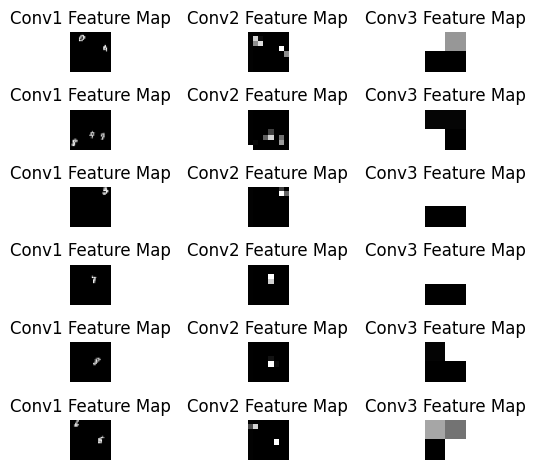

In [254]:
model_single_classification.visulize_feature_maps(train_loader_classification, device=device)

In [255]:
class CNN_HyperParameterTuning(nn.Module):
    def __init__(self, num_classes=10, num_conv_layers=3, dropout_rate=0.0, task='classification'):
        super(CNN_HyperParameterTuning, self).__init__()
        
        self.task = task
        self.num_classes = num_classes
        self.num_conv_layers = num_conv_layers
        self.dropout_rate = dropout_rate
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        for i in range(num_conv_layers):
            if i == 0:
                setattr(self, f'conv{i+1}', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1))
            else:
                setattr(self, f'conv{i+1}', nn.Conv2d(in_channels=32*(2**(i-1)), out_channels=32*(2**i), kernel_size=3, stride=2, padding=1))
            
            setattr(self, f'dropout{i+1}', nn.Dropout(dropout_rate))

        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        self.fc_dropout = nn.Dropout(dropout_rate)
        
        if task == 'classification':
            self.fc3 = nn.Linear(64, num_classes)
        elif task == 'regression':
            self.fc3 = nn.Linear(64, 1)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output, _ = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        feature_maps = {}
        for i in range(self.num_conv_layers):
            conv_layer = getattr(self, f'conv{i+1}')
            dropout_layer = getattr(self, f'dropout{i+1}')
            x = self.pool(self.relu(conv_layer(x)))
            x = dropout_layer(x)
            feature_maps[f'conv{i+1}'] = x
        return x, feature_maps

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x, feature_maps = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc_dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x, feature_maps

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            y_pred, feature_maps = self.forward(x)
        return y_pred, feature_maps

    def get_accuracy(self, y_pred, y_true):
        if self.task == 'classification':
            y_pred = torch.argmax(y_pred, dim=1)
            return (y_pred == y_true).float().mean()
        elif self.task == 'regression':
            y_pred = torch.round(y_pred)
            return (y_pred == y_true).float().mean()

    def loss(self, y_pred, y_true):
        if self.task == 'classification':
            return F.cross_entropy(y_pred, y_true)
        elif self.task == 'regression':
            return F.mse_loss(y_pred, y_true)

    def train_model(self, optimizer, train_loader, val_loader, num_epochs=10, device='cpu'):
        self.to(device)
        train_losses = []
        val_losses = []
        
        for epoch in range(num_epochs):
            self.train()
            total_train_loss = 0.0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred, _ = self.forward(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            self.eval()
            total_val_loss = 0.0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    y_pred, _ = self.forward(x)
                    total_val_loss += self.loss(y_pred, y).item()
            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

        return train_losses, val_losses


In [256]:
def tune(train_loader, val_loader, test_loader, configs, num_epochs=10, device='cpu'):
    results = {}
    
    for config in configs:
        print(f"Running with config: {config}")
        
        model = CNN_HyperParameterTuning(num_classes=config['num_classes'], num_conv_layers=config['conv_layers'],
                    dropout_rate=config['dropout_rate'], task=config['task']).to(device)
        
        if config['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        elif config['optimizer'] == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
        elif config['optimizer'] == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=config['learning_rate'])
        
        train_loss, val_loss = model.train_model(optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device)
        
        results[str(config)] = {
            'train_loss': train_loss,
            'val_loss': val_loss
        }
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.title(f"Loss for config: {config}")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        model.eval()
        total_test_loss = 0.0
        total_accuracy = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_pred, _ = model.forward(x)
                total_test_loss += model.loss(y_pred, y).item()
                total_accuracy += model.get_accuracy(y_pred, y).item()     
        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_accuracy = total_accuracy / len(test_loader)
        
        print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}")
    
    return results


Running with config: {'task': 'classification', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'conv_layers': 3, 'optimizer': 'Adam', 'num_classes': 4}


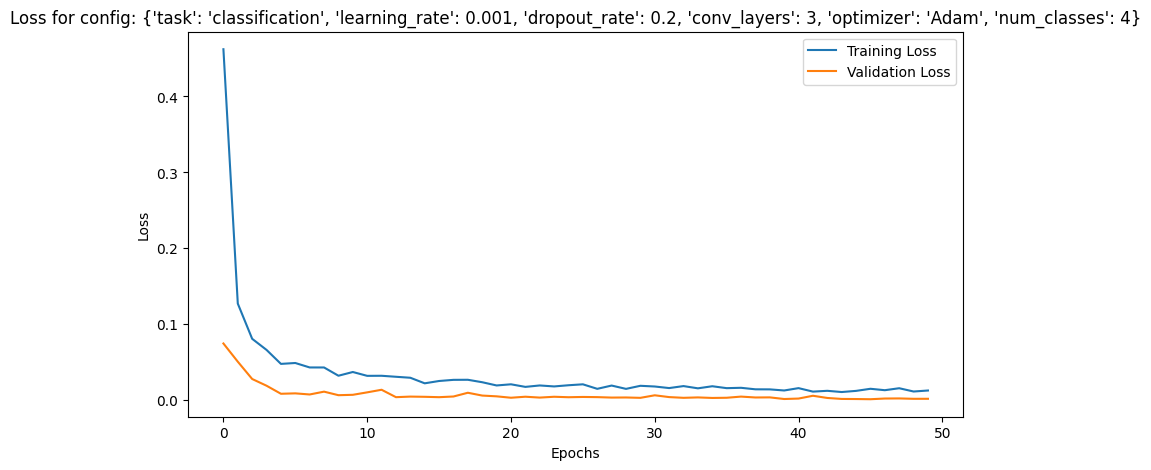

Test Loss: 0.0015, Test Accuracy: 0.9993
Running with config: {'task': 'classification', 'learning_rate': 0.0005, 'dropout_rate': 0.3, 'conv_layers': 3, 'optimizer': 'SGD', 'momentum': 0.9, 'num_classes': 4}


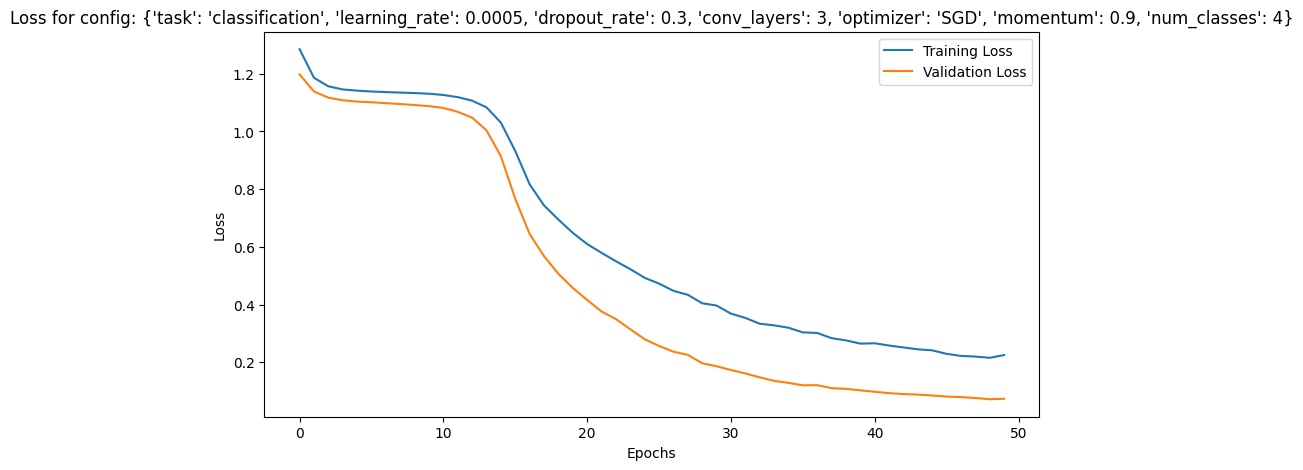

Test Loss: 0.0758, Test Accuracy: 0.9902
Running with config: {'task': 'classification', 'learning_rate': 0.002, 'dropout_rate': 0.4, 'conv_layers': 3, 'optimizer': 'RMSprop', 'num_classes': 4}


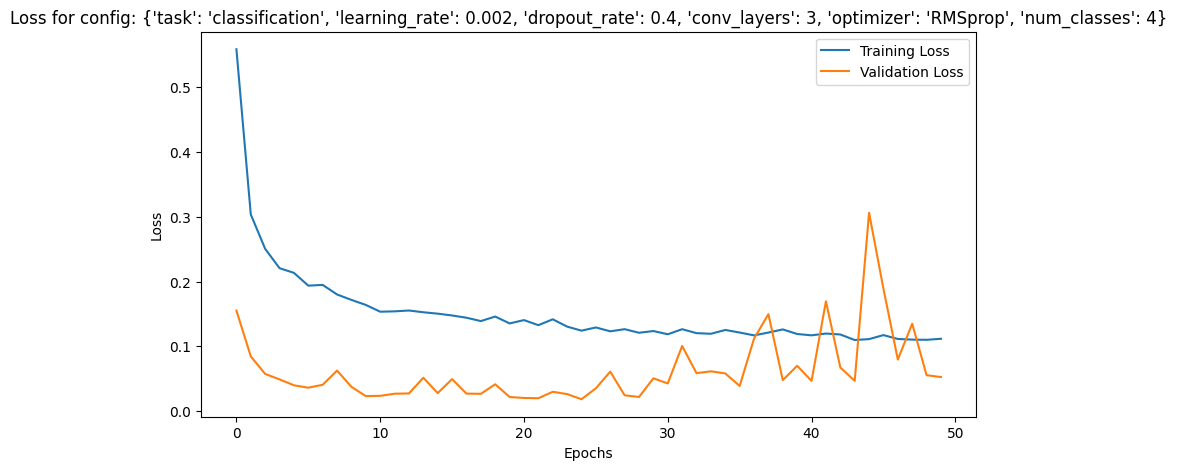

Test Loss: 0.0445, Test Accuracy: 0.9859
Running with config: {'task': 'classification', 'learning_rate': 0.0001, 'dropout_rate': 0.25, 'conv_layers': 2, 'optimizer': 'Adam', 'num_classes': 4}


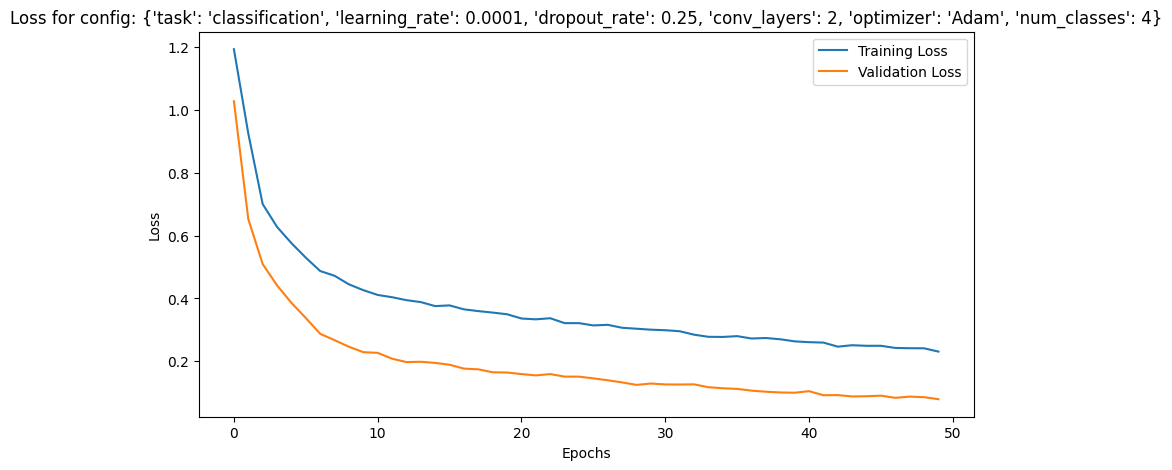

Test Loss: 0.1024, Test Accuracy: 0.9857
Running with config: {'task': 'classification', 'learning_rate': 0.005, 'dropout_rate': 0.1, 'conv_layers': 2, 'optimizer': 'SGD', 'momentum': 0.85, 'num_classes': 4}


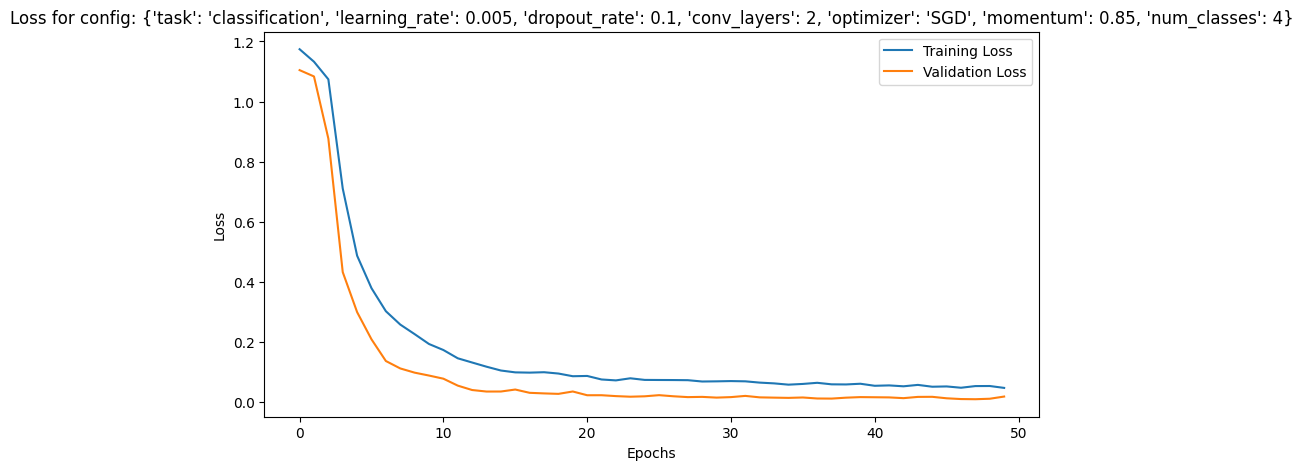

Test Loss: 0.0121, Test Accuracy: 0.9967
Running with config: {'task': 'classification', 'learning_rate': 0.001, 'dropout_rate': 0.0, 'conv_layers': 2, 'optimizer': 'Adam', 'num_classes': 4}


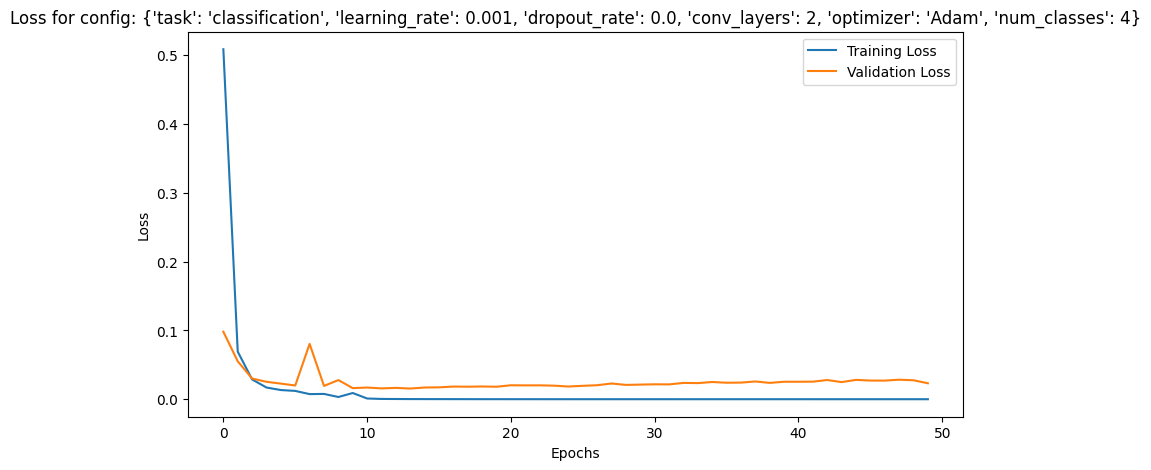

Test Loss: 0.0104, Test Accuracy: 0.9982


In [257]:
classification_configs = [
    {
        "task": "classification",
        "learning_rate": 0.001,
        "dropout_rate": 0.2,
        "conv_layers": 3,
        "optimizer": "Adam",
        "num_classes": 4
    },
    {
        "task": "classification",
        "learning_rate": 0.0005,
        "dropout_rate": 0.3,
        "conv_layers": 3,
        "optimizer": "SGD",
        "momentum": 0.9,
        "num_classes": 4
    },
    {
        "task": "classification",
        "learning_rate": 0.002,
        "dropout_rate": 0.4,
        "conv_layers": 3,
        "optimizer": "RMSprop",
        "num_classes": 4
    },
    {
        "task": "classification",
        "learning_rate": 0.0001,
        "dropout_rate": 0.25,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 4
    },
    {
        "task": "classification",
        "learning_rate": 0.005,
        "dropout_rate": 0.1,
        "conv_layers": 2,
        "optimizer": "SGD",
        "momentum": 0.85,
        "num_classes": 4
    },

    {
        "task": "classification",
        "learning_rate": 0.001,
        "dropout_rate": 0.0,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 4
    }
]

results = tune(train_loader_classification, val_loader_classification, test_loader_classification, classification_configs, num_epochs=50, device=device)


In [258]:
train_data_regression = MultiMNISTDataset(train_data, train_labels, task='regression')
val_data_regression = MultiMNISTDataset(val_data, val_labels, task='regression')
test_data_regression = MultiMNISTDataset(test_data, test_labels, task='regression')

train_loader_regression = DataLoader(train_data_regression, batch_size=32, shuffle=True)
val_loader_regression = DataLoader(val_data_regression, batch_size=32, shuffle=False)
test_loader_regression = DataLoader(test_data_regression, batch_size=32, shuffle=False)

In [259]:
model_single_regression = CNN(task='regression').to(device)
optimizer = torch.optim.Adam(model_single_regression.parameters(), lr=0.001)
model_single_regression.train_model(optimizer, train_loader_regression, val_loader_regression, num_epochs=15, device=device)

Epoch 1/15: 100%|██████████| 394/394 [00:05<00:00, 75.68it/s, Loss=0.0712]


Epoch 1, Validation Accuracy: 97.64%, Validation Loss: 0.048123


Epoch 2/15: 100%|██████████| 394/394 [00:04<00:00, 78.98it/s, Loss=0.0271]


Epoch 2, Validation Accuracy: 98.97%, Validation Loss: 0.025704


Epoch 3/15: 100%|██████████| 394/394 [00:05<00:00, 72.39it/s, Loss=0.0105]


Epoch 3, Validation Accuracy: 99.77%, Validation Loss: 0.016846


Epoch 4/15: 100%|██████████| 394/394 [00:04<00:00, 82.91it/s, Loss=0.0094]


Epoch 4, Validation Accuracy: 99.70%, Validation Loss: 0.015336


Epoch 5/15: 100%|██████████| 394/394 [00:04<00:00, 80.53it/s, Loss=0.0068]


Epoch 5, Validation Accuracy: 99.97%, Validation Loss: 0.011969


Epoch 6/15: 100%|██████████| 394/394 [00:04<00:00, 81.42it/s, Loss=0.0090]


Epoch 6, Validation Accuracy: 99.97%, Validation Loss: 0.010053


Epoch 7/15: 100%|██████████| 394/394 [00:04<00:00, 82.04it/s, Loss=0.0059]


Epoch 7, Validation Accuracy: 99.83%, Validation Loss: 0.010766


Epoch 8/15: 100%|██████████| 394/394 [00:04<00:00, 81.81it/s, Loss=0.0079]


Epoch 8, Validation Accuracy: 100.00%, Validation Loss: 0.013723


Epoch 9/15: 100%|██████████| 394/394 [00:04<00:00, 82.10it/s, Loss=0.0057]


Epoch 9, Validation Accuracy: 100.00%, Validation Loss: 0.007707


Epoch 10/15: 100%|██████████| 394/394 [00:04<00:00, 80.72it/s, Loss=0.0049]


Epoch 10, Validation Accuracy: 100.00%, Validation Loss: 0.009405


Epoch 11/15: 100%|██████████| 394/394 [00:04<00:00, 81.24it/s, Loss=0.0072]


Epoch 11, Validation Accuracy: 100.00%, Validation Loss: 0.006593


Epoch 12/15: 100%|██████████| 394/394 [00:04<00:00, 82.32it/s, Loss=0.0066]


Epoch 12, Validation Accuracy: 100.00%, Validation Loss: 0.007841


Epoch 13/15: 100%|██████████| 394/394 [00:05<00:00, 74.66it/s, Loss=0.0108]


Epoch 13, Validation Accuracy: 100.00%, Validation Loss: 0.009720


Epoch 14/15: 100%|██████████| 394/394 [00:04<00:00, 81.23it/s, Loss=0.0099]


Epoch 14, Validation Accuracy: 100.00%, Validation Loss: 0.006555


Epoch 15/15: 100%|██████████| 394/394 [00:04<00:00, 80.85it/s, Loss=0.0040]


Epoch 15, Validation Accuracy: 100.00%, Validation Loss: 0.006055


Running with config: {'task': 'regression', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'conv_layers': 3, 'optimizer': 'Adam', 'num_classes': 4}


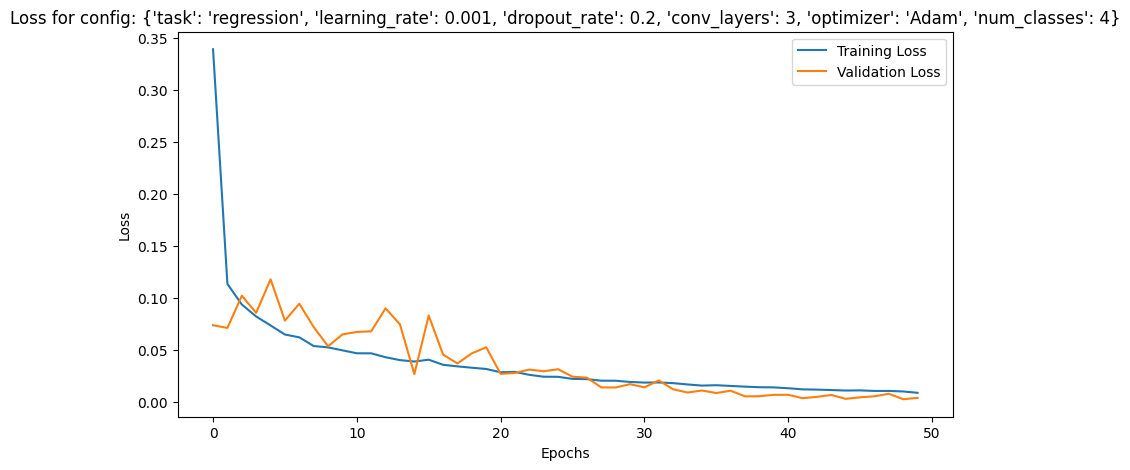

Test Loss: 0.0039, Test Accuracy: 0.9983
Running with config: {'task': 'regression', 'learning_rate': 0.0005, 'dropout_rate': 0.3, 'conv_layers': 3, 'optimizer': 'SGD', 'momentum': 0.9, 'num_classes': 4}


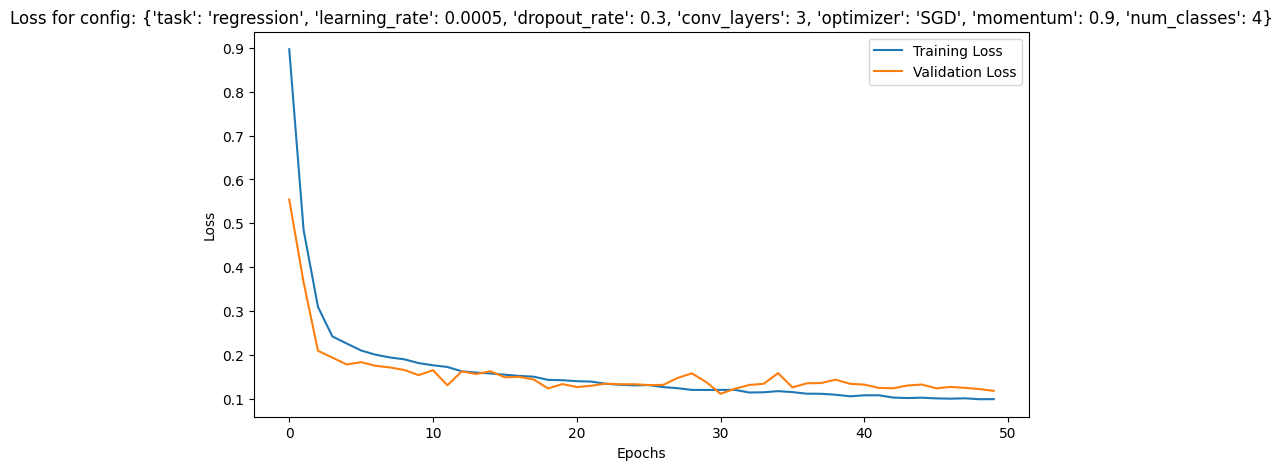

Test Loss: 0.0991, Test Accuracy: 0.8796
Running with config: {'task': 'regression', 'learning_rate': 0.002, 'dropout_rate': 0.4, 'conv_layers': 3, 'optimizer': 'RMSprop', 'num_classes': 4}


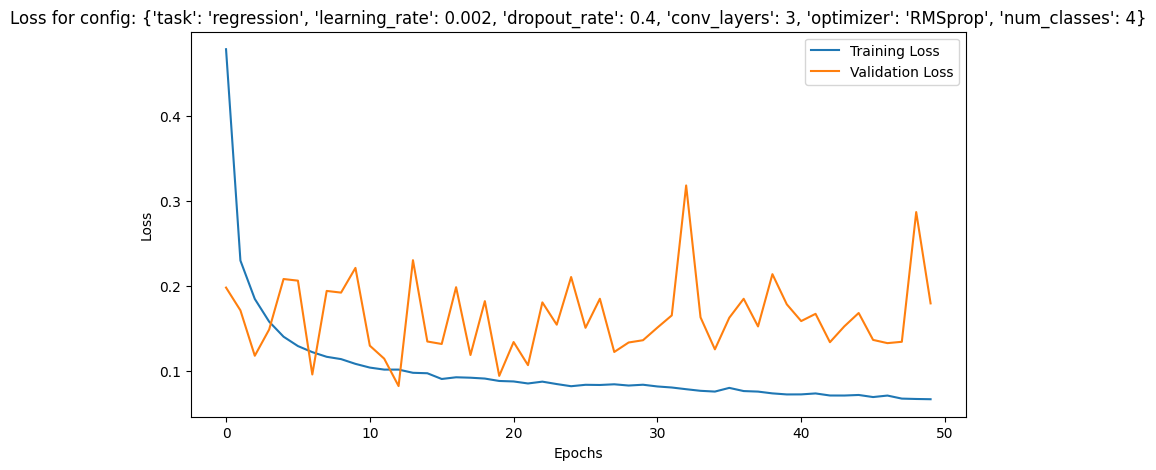

Test Loss: 0.1527, Test Accuracy: 0.7619
Running with config: {'task': 'regression', 'learning_rate': 0.0001, 'dropout_rate': 0.25, 'conv_layers': 2, 'optimizer': 'Adam', 'num_classes': 4}


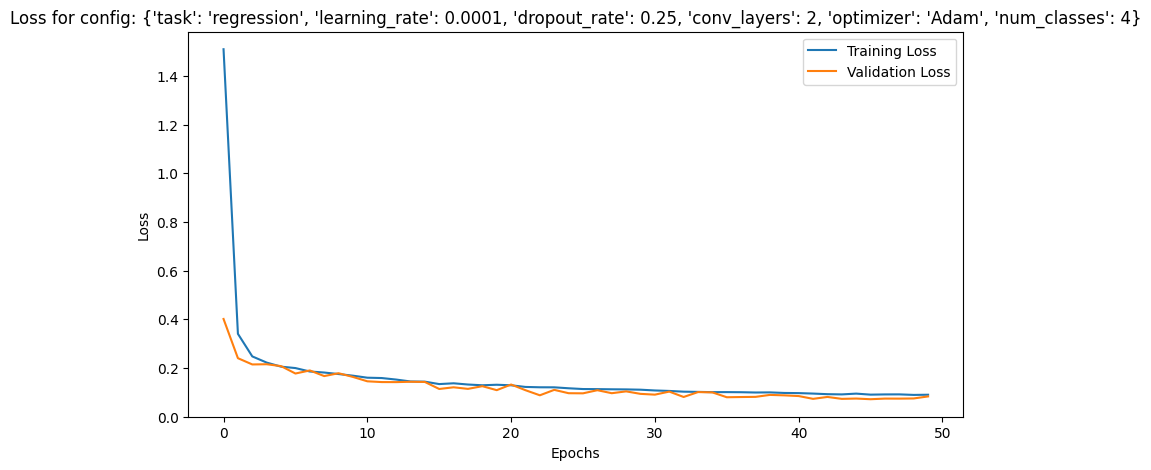

Test Loss: 0.0722, Test Accuracy: 0.9450
Running with config: {'task': 'regression', 'learning_rate': 0.005, 'dropout_rate': 0.1, 'conv_layers': 2, 'optimizer': 'SGD', 'momentum': 0.85, 'num_classes': 4}


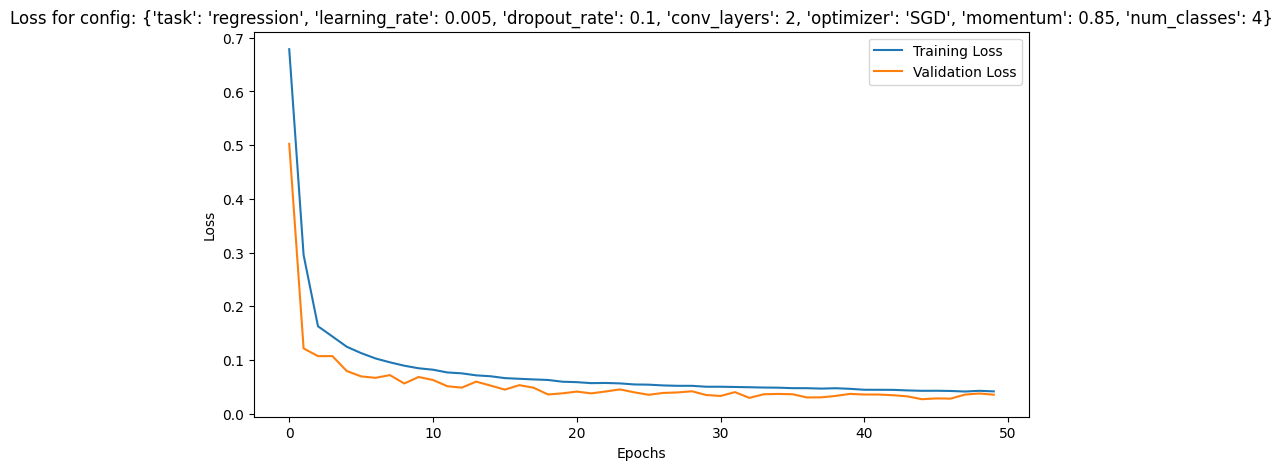

Test Loss: 0.0299, Test Accuracy: 0.9905
Running with config: {'task': 'regression', 'learning_rate': 0.001, 'dropout_rate': 0.0, 'conv_layers': 2, 'optimizer': 'Adam', 'num_classes': 4}


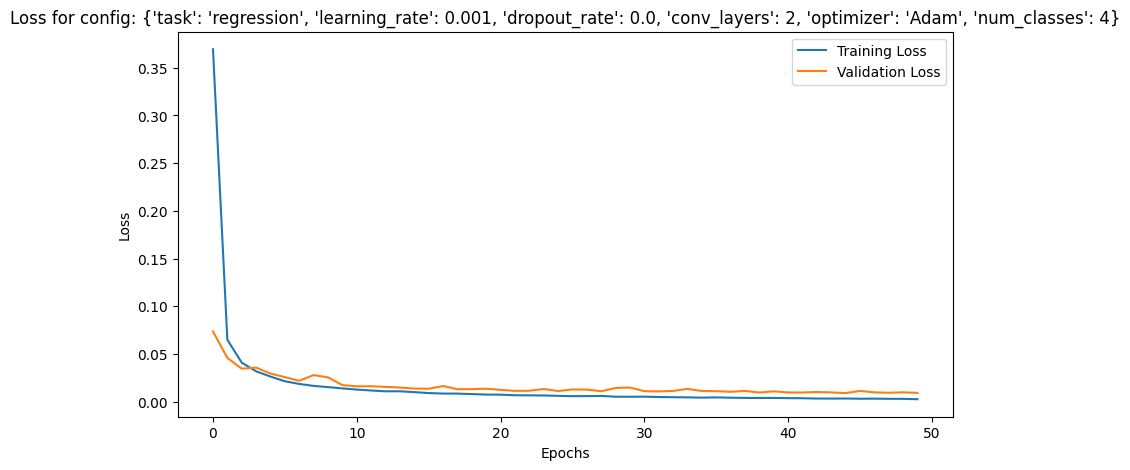

Test Loss: 0.0088, Test Accuracy: 0.9993


In [260]:
regression_configs = [
    {
        "task": "regression",
        "learning_rate": 0.001,
        "dropout_rate": 0.2,
        "conv_layers": 3,
        "optimizer": "Adam",
        "num_classes": 4
    },
    {
        "task": "regression",
        "learning_rate": 0.0005,
        "dropout_rate": 0.3,
        "conv_layers": 3,
        "optimizer": "SGD",
        "momentum": 0.9,
        "num_classes": 4
    },
    {
        "task": "regression",
        "learning_rate": 0.002,
        "dropout_rate": 0.4,
        "conv_layers": 3,
        "optimizer": "RMSprop",
        "num_classes": 4
    },
    {
        "task": "regression",
        "learning_rate": 0.0001,
        "dropout_rate": 0.25,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 4
    },
    {
        "task": "regression",
        "learning_rate": 0.005,
        "dropout_rate": 0.1,
        "conv_layers": 2,
        "optimizer": "SGD",
        "momentum": 0.85,
        "num_classes": 4
    },

    {
        "task": "regression",
        "learning_rate": 0.001,
        "dropout_rate": 0.0,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 4
    }
]

results = tune(train_loader_regression, val_loader_regression, test_loader_regression, regression_configs, num_epochs=50, device=device)

### Multilabel Classification

In [261]:
def load_mnist_data_multilabel(path):
    splits = ['train', 'val', 'test']
    data = {'train': [], 'val': [], 'test': []}
    labels = {'train': [], 'val': [], 'test': []}
    for split in splits:
        split_path = os.path.join(path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if (len(label) == 1 and int(label) == 0):
                cur_label = []
            else:
                cur_label = [int(i) for i in label]
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    try:
                        image = Image.open(image_path).convert('L')
                        image_array = np.array(image)
                        data[split].append(image_array)
                        labels[split].append(cur_label)
                    except Exception as e:
                        print(f"Error loading image {image_name}: {e}")
    
    return data['train'], labels['train'], data['val'], labels['val'], data['test'], labels['test']

In [262]:
def get_one_hot(y):
    one_hot = np.zeros(33)
    if len(y) == 0:
        y.append(10)
        y.append(10)
        y.append(10)
    elif len(y) == 1:
        y.append(10)
        y.append(10)
    elif len(y) == 2:
        y.append(10)
    for i in range(len(y)):
        one_hot[y[i]+10*i+i] = 1
    return one_hot

In [263]:
class MultiMNISTDataset_mulitlabel(Dataset):
    def __init__(self, images, labels, task='multilabel_classification', transform=None):
        self.images = images
        self.labels = labels
        self.task = task
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        if self.task == 'multilabel_classification':
            label = torch.tensor(label, dtype=torch.float32).to(device)
        else:
            label = torch.tensor(label, dtype=torch.float32).to(device).unsqueeze(0)
        return image, label


In [264]:
class CNN_Multilabel(nn.Module):
    def __init__(self, task='multilabel_classification', num_classes=33):
        super(CNN_Multilabel, self).__init__()
        
        self.task = task
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        return x

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_accuracy(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            y_pred_labels = self.convert_to_labels(y_pred)
            y_true_labels = self.convert_to_labels(y_true)
            accuracy = 0
            for i in range(len(y_pred_labels)):
                flag = 1
                if len(y_pred_labels[i]) == len(y_true_labels[i]):
                    for j in range(len(y_pred_labels[i])):
                        if y_pred_labels[i][j] != y_true_labels[i][j]:
                            flag = 0
                            break
                else:
                    flag = 0
                accuracy += flag
            return accuracy/len(y_pred_labels)
        else:
            return F.mse_loss(y_pred, y_true)


    def loss(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            criterion = nn.CrossEntropyLoss()
            loss = 0
            for i in range(3):
                start = i * 11
                end = (i + 1) * 11
                target_idx = torch.argmax(y_true[:, start:end], dim=1)
                loss += criterion(y_pred[:, start:end], target_idx)
            return loss
        else:
            return F.mse_loss(y_pred, y_true)
            
    def convert_to_labels(self, y_pred):
        labels = []
        batch_size = y_pred.shape[0]
        for i in range(batch_size):
            label = []
            for j in range(3):
                start = j * 11
                end = (j + 1) * 11
                cur_label = torch.argmax(y_pred[i, start:end]).item()
                if cur_label != 10:
                    label.append(cur_label)
                else:
                    break
            labels.append(label)
        return labels
    
    def train_model(self, optimizer, train_loader, val_loader, num_epochs=30, device='cpu'):
        self.to(device)
        for epoch in range(num_epochs):
            self.train()
            train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
            
            for i, (x, y) in train_progress:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = self.forward(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                optimizer.step()
                train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
            
            self.eval()
            total_accuracy = 0
            total_loss = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    y_pred = self.forward(x)
                    total_loss += self.loss(y_pred, y).item()
                    total_accuracy += self.get_accuracy(y_pred, y)

                avg_loss = total_loss / len(val_loader)
                accuracy = total_accuracy / len(val_loader)
                print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy*100:.2f}%, Validation Loss: {avg_loss:.6f}")

In [265]:
train_data_multilabel, train_labels_multilabel, val_data_multilabel, val_labels_multilabel, test_data_multilabel, test_labels_multilabel = load_mnist_data_multilabel(data_path)

In [266]:
train_labels_multilabel_one_hot = [get_one_hot(y) for y in train_labels_multilabel]
val_labels_multilabel_one_hot = [get_one_hot(y) for y in val_labels_multilabel]
test_labels_multilabel_one_hot = [get_one_hot(y) for y in test_labels_multilabel]

In [267]:

train_data_multilabel = MultiMNISTDataset_mulitlabel(train_data_multilabel, train_labels_multilabel_one_hot)
val_data_multilabel = MultiMNISTDataset_mulitlabel(val_data_multilabel, val_labels_multilabel_one_hot)
test_data_multilabel = MultiMNISTDataset_mulitlabel(test_data_multilabel, test_labels_multilabel_one_hot)

train_loader_multilabel = DataLoader(train_data_multilabel, batch_size=32, shuffle=True)
val_loader_multilabel = DataLoader(val_data_multilabel, batch_size=32, shuffle=False)
test_loader_multilabel = DataLoader(test_data_multilabel, batch_size=32, shuffle=False)

In [268]:
model_multilabel_classfication = CNN_Multilabel(task='multilabel_classification', num_classes=33).to(device)

optimizer = torch.optim.Adam(model_multilabel_classfication.parameters(), lr=0.001)
model_multilabel_classfication.train_model(optimizer, train_loader_multilabel, val_loader_multilabel, num_epochs=50, device=device)

Epoch 1/50: 100%|██████████| 394/394 [00:05<00:00, 66.98it/s, Loss=4.5609]


Epoch 1, Validation Accuracy: 4.89%, Validation Loss: 4.949263


Epoch 2/50: 100%|██████████| 394/394 [00:05<00:00, 69.54it/s, Loss=3.3512]


Epoch 2, Validation Accuracy: 5.59%, Validation Loss: 5.014621


Epoch 3/50: 100%|██████████| 394/394 [00:05<00:00, 69.85it/s, Loss=3.5104]


Epoch 3, Validation Accuracy: 4.79%, Validation Loss: 4.967268


Epoch 4/50: 100%|██████████| 394/394 [00:05<00:00, 69.51it/s, Loss=3.6253]


Epoch 4, Validation Accuracy: 5.36%, Validation Loss: 4.805582


Epoch 5/50: 100%|██████████| 394/394 [00:05<00:00, 70.10it/s, Loss=3.2773]


Epoch 5, Validation Accuracy: 5.77%, Validation Loss: 4.694983


Epoch 6/50: 100%|██████████| 394/394 [00:05<00:00, 70.50it/s, Loss=3.8691]


Epoch 6, Validation Accuracy: 6.08%, Validation Loss: 4.779000


Epoch 7/50: 100%|██████████| 394/394 [00:06<00:00, 65.36it/s, Loss=2.6098]


Epoch 7, Validation Accuracy: 4.99%, Validation Loss: 4.806759


Epoch 8/50: 100%|██████████| 394/394 [00:05<00:00, 69.52it/s, Loss=3.1281]


Epoch 8, Validation Accuracy: 5.65%, Validation Loss: 4.879750


Epoch 9/50: 100%|██████████| 394/394 [00:05<00:00, 69.78it/s, Loss=2.6414]


Epoch 9, Validation Accuracy: 5.27%, Validation Loss: 4.703075


Epoch 10/50: 100%|██████████| 394/394 [00:06<00:00, 63.30it/s, Loss=2.4310]


Epoch 10, Validation Accuracy: 6.34%, Validation Loss: 4.660413


Epoch 11/50: 100%|██████████| 394/394 [00:07<00:00, 52.76it/s, Loss=2.5310]


Epoch 11, Validation Accuracy: 5.56%, Validation Loss: 5.415875


Epoch 12/50: 100%|██████████| 394/394 [00:07<00:00, 50.86it/s, Loss=2.1362]


Epoch 12, Validation Accuracy: 6.78%, Validation Loss: 4.988204


Epoch 13/50: 100%|██████████| 394/394 [00:06<00:00, 59.58it/s, Loss=2.2349]


Epoch 13, Validation Accuracy: 7.52%, Validation Loss: 4.815725


Epoch 14/50: 100%|██████████| 394/394 [00:06<00:00, 60.81it/s, Loss=2.1711]


Epoch 14, Validation Accuracy: 10.57%, Validation Loss: 4.824198


Epoch 15/50: 100%|██████████| 394/394 [00:06<00:00, 62.86it/s, Loss=1.7046]


Epoch 15, Validation Accuracy: 10.00%, Validation Loss: 4.384574


Epoch 16/50: 100%|██████████| 394/394 [00:06<00:00, 62.13it/s, Loss=2.2293]


Epoch 16, Validation Accuracy: 9.98%, Validation Loss: 4.614690


Epoch 17/50: 100%|██████████| 394/394 [00:06<00:00, 62.70it/s, Loss=2.3641]


Epoch 17, Validation Accuracy: 11.50%, Validation Loss: 4.064878


Epoch 18/50: 100%|██████████| 394/394 [00:05<00:00, 66.78it/s, Loss=2.3803]


Epoch 18, Validation Accuracy: 12.49%, Validation Loss: 4.384173


Epoch 19/50: 100%|██████████| 394/394 [00:06<00:00, 64.87it/s, Loss=1.3545]


Epoch 19, Validation Accuracy: 12.46%, Validation Loss: 4.559413


Epoch 20/50: 100%|██████████| 394/394 [00:06<00:00, 65.19it/s, Loss=1.4258]


Epoch 20, Validation Accuracy: 16.57%, Validation Loss: 4.214364


Epoch 21/50: 100%|██████████| 394/394 [00:09<00:00, 41.71it/s, Loss=1.4273]


Epoch 21, Validation Accuracy: 16.31%, Validation Loss: 4.533709


Epoch 22/50: 100%|██████████| 394/394 [00:06<00:00, 60.11it/s, Loss=2.1244]


Epoch 22, Validation Accuracy: 16.86%, Validation Loss: 4.289092


Epoch 23/50: 100%|██████████| 394/394 [00:06<00:00, 61.79it/s, Loss=1.1751]


Epoch 23, Validation Accuracy: 18.35%, Validation Loss: 4.177233


Epoch 24/50: 100%|██████████| 394/394 [00:08<00:00, 44.67it/s, Loss=1.7661]


Epoch 24, Validation Accuracy: 18.68%, Validation Loss: 4.384163


Epoch 25/50: 100%|██████████| 394/394 [00:08<00:00, 47.11it/s, Loss=1.0832]


Epoch 25, Validation Accuracy: 19.80%, Validation Loss: 4.369044


Epoch 26/50: 100%|██████████| 394/394 [00:09<00:00, 41.68it/s, Loss=1.4345]


Epoch 26, Validation Accuracy: 20.42%, Validation Loss: 4.569493


Epoch 27/50: 100%|██████████| 394/394 [00:08<00:00, 48.96it/s, Loss=1.3516]


Epoch 27, Validation Accuracy: 21.84%, Validation Loss: 4.641950


Epoch 28/50: 100%|██████████| 394/394 [00:09<00:00, 39.48it/s, Loss=1.1052]


Epoch 28, Validation Accuracy: 22.64%, Validation Loss: 4.283044


Epoch 29/50: 100%|██████████| 394/394 [00:09<00:00, 40.44it/s, Loss=1.0253]


Epoch 29, Validation Accuracy: 23.47%, Validation Loss: 4.668219


Epoch 30/50: 100%|██████████| 394/394 [00:07<00:00, 52.54it/s, Loss=0.8586]


Epoch 30, Validation Accuracy: 22.94%, Validation Loss: 4.393604


Epoch 31/50: 100%|██████████| 394/394 [00:05<00:00, 67.03it/s, Loss=0.6902]


Epoch 31, Validation Accuracy: 23.52%, Validation Loss: 4.737546


Epoch 32/50: 100%|██████████| 394/394 [00:05<00:00, 73.63it/s, Loss=1.0918]


Epoch 32, Validation Accuracy: 25.55%, Validation Loss: 4.530822


Epoch 33/50: 100%|██████████| 394/394 [00:05<00:00, 69.88it/s, Loss=1.3778]


Epoch 33, Validation Accuracy: 24.22%, Validation Loss: 5.139753


Epoch 34/50: 100%|██████████| 394/394 [00:05<00:00, 69.55it/s, Loss=0.9255]


Epoch 34, Validation Accuracy: 23.81%, Validation Loss: 5.040895


Epoch 35/50: 100%|██████████| 394/394 [00:05<00:00, 68.07it/s, Loss=0.6127]


Epoch 35, Validation Accuracy: 23.01%, Validation Loss: 4.991399


Epoch 36/50: 100%|██████████| 394/394 [00:06<00:00, 64.93it/s, Loss=0.6181]


Epoch 36, Validation Accuracy: 24.36%, Validation Loss: 5.399884


Epoch 37/50: 100%|██████████| 394/394 [00:04<00:00, 79.49it/s, Loss=0.7955]


Epoch 37, Validation Accuracy: 25.93%, Validation Loss: 5.124868


Epoch 38/50: 100%|██████████| 394/394 [00:06<00:00, 63.29it/s, Loss=0.5194]


Epoch 38, Validation Accuracy: 26.10%, Validation Loss: 5.009622


Epoch 39/50: 100%|██████████| 394/394 [00:05<00:00, 70.46it/s, Loss=1.0963]


Epoch 39, Validation Accuracy: 26.34%, Validation Loss: 5.308794


Epoch 40/50: 100%|██████████| 394/394 [00:06<00:00, 56.96it/s, Loss=0.7147]


Epoch 40, Validation Accuracy: 25.62%, Validation Loss: 5.925610


Epoch 41/50: 100%|██████████| 394/394 [00:06<00:00, 61.50it/s, Loss=0.6887]


Epoch 41, Validation Accuracy: 25.58%, Validation Loss: 6.278671


Epoch 42/50: 100%|██████████| 394/394 [00:05<00:00, 67.86it/s, Loss=0.3771]


Epoch 42, Validation Accuracy: 25.89%, Validation Loss: 5.811889


Epoch 43/50: 100%|██████████| 394/394 [00:05<00:00, 70.97it/s, Loss=0.2136]


Epoch 43, Validation Accuracy: 26.16%, Validation Loss: 6.101171


Epoch 44/50: 100%|██████████| 394/394 [00:04<00:00, 79.85it/s, Loss=0.3875]


Epoch 44, Validation Accuracy: 25.09%, Validation Loss: 6.479164


Epoch 45/50: 100%|██████████| 394/394 [00:04<00:00, 83.00it/s, Loss=0.6261]


Epoch 45, Validation Accuracy: 25.12%, Validation Loss: 6.319007


Epoch 46/50: 100%|██████████| 394/394 [00:04<00:00, 82.87it/s, Loss=0.3556]


Epoch 46, Validation Accuracy: 26.73%, Validation Loss: 6.158909


Epoch 47/50: 100%|██████████| 394/394 [00:04<00:00, 82.89it/s, Loss=0.2216]


Epoch 47, Validation Accuracy: 26.78%, Validation Loss: 6.431930


Epoch 48/50: 100%|██████████| 394/394 [00:04<00:00, 82.89it/s, Loss=0.1199]


Epoch 48, Validation Accuracy: 25.81%, Validation Loss: 7.061147


Epoch 49/50: 100%|██████████| 394/394 [00:05<00:00, 74.91it/s, Loss=0.2082]


Epoch 49, Validation Accuracy: 27.15%, Validation Loss: 6.816955


Epoch 50/50: 100%|██████████| 394/394 [00:04<00:00, 84.00it/s, Loss=0.1559]


Epoch 50, Validation Accuracy: 25.53%, Validation Loss: 7.883048


In [269]:
class CNN_Multilabel_HyperParameterTuning(nn.Module):
    def __init__(self, num_classes=33, num_conv_layers=3, dropout_rate=0.0, task='multilabel_classification'):
        super(CNN_Multilabel_HyperParameterTuning, self).__init__()

        self.task = task
        self.num_classes = num_classes
        self.num_conv_layers = num_conv_layers
        self.dropout_rate = dropout_rate
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for i in range(num_conv_layers):
            if i == 0:
                setattr(self, f'conv{i+1}', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1))
            else:
                setattr(self, f'conv{i+1}', nn.Conv2d(in_channels=32 * (2 ** (i - 1)), out_channels=32 * (2 ** i), kernel_size=3, stride=2, padding=1))
            
            setattr(self, f'dropout{i+1}', nn.Dropout(dropout_rate))

        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.fc_dropout = nn.Dropout(dropout_rate)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        for i in range(self.num_conv_layers):
            conv_layer = getattr(self, f'conv{i+1}')
            dropout_layer = getattr(self, f'dropout{i+1}')
            x = self.pool(self.relu(conv_layer(x)))
            x = dropout_layer(x)
        return x

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc_dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_accuracy(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            y_pred_labels = self.convert_to_labels(y_pred)
            y_true_labels = self.convert_to_labels(y_true)
            accuracy = 0
            for i in range(len(y_pred_labels)):
                flag = 1
                if len(y_pred_labels[i]) == len(y_true_labels[i]):
                    for j in range(len(y_pred_labels[i])):
                        if y_pred_labels[i][j] != y_true_labels[i][j]:
                            flag = 0
                            break
                else:
                    flag = 0
                accuracy += flag
            return accuracy / len(y_pred_labels)
        else:
            return F.mse_loss(y_pred, y_true)

    def loss(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            criterion = nn.CrossEntropyLoss()
            loss = 0
            for i in range(3):
                start = i * 11
                end = (i + 1) * 11
                target_idx = torch.argmax(y_true[:, start:end], dim=1)
                loss += criterion(y_pred[:, start:end], target_idx)
            return loss
        else:
            return F.mse_loss(y_pred, y_true)

    def convert_to_labels(self, y_pred):
        labels = []
        batch_size = y_pred.shape[0]
        for i in range(batch_size):
            label = []
            for j in range(3):
                start = j * 11
                end = (j + 1) * 11
                cur_label = torch.argmax(y_pred[i, start:end]).item()
                if cur_label != 10:
                    label.append(cur_label)
                else:
                    break
            labels.append(label)
        return labels
    
    def train_model(self, optimizer, train_loader, val_loader, num_epochs=30, device='cpu'):
        self.to(device)
        avg_train_losses = []
        avg_val_losses = []

        for epoch in range(num_epochs):
            self.train()
            total_train_loss = 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = self.forward(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
            avg_train_loss = total_train_loss / len(train_loader)
            avg_train_losses.append(avg_train_loss)
            
            self.eval()
            total_val_loss = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    y_pred = self.forward(x)
                    total_val_loss += self.loss(y_pred, y).item()
            avg_val_loss = total_val_loss / len(val_loader)
            avg_val_losses.append(avg_val_loss)

        return avg_train_losses, avg_val_losses


In [270]:
def tune_multilabel(train_loader, val_loader, test_loader, configs, num_epochs=30, device='cpu'):
    results = {}

    for config in configs:
        model = CNN_Multilabel_HyperParameterTuning(
            num_classes=config['num_classes'], 
            num_conv_layers=config['conv_layers'], 
            dropout_rate=config['dropout_rate'], 
            task=config['task']
        ).to(device)

        if config['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        elif config['optimizer'] == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
        elif config['optimizer'] == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=config['learning_rate'])

        train_losses, val_losses = model.train_model(optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device)

        results[str(config)] = {
            'train_loss': train_losses,
            'val_loss': val_losses
        }

        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Training and Validation Loss for Config: {config}")
        plt.legend()
        plt.show()
        
        model.eval()
        total_test_loss = 0.0
        total_accuracy = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model.forward(x)
                total_test_loss += model.loss(y_pred, y).item()
                total_accuracy += model.get_accuracy(y_pred, y)

        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_accuracy = total_accuracy / len(test_loader)

        results[str(config)].update({
            'test_loss': avg_test_loss,
            'test_accuracy': avg_test_accuracy
        })

    return results


In [271]:
multilabel_classification_configs = [
    {
        "task": "multilabel_classification",
        "learning_rate": 0.001,
        "dropout_rate": 0.2,
        "conv_layers": 3,
        "optimizer": "Adam",
        "num_classes": 33
    },
    {
        "task": "multilabel_classification",
        "learning_rate": 0.0005,
        "dropout_rate": 0.3,
        "conv_layers": 3,
        "optimizer": "SGD",
        "momentum": 0.9,
        "num_classes": 33
    },
    {
        "task": "multilabel_classification",
        "learning_rate": 0.002,
        "dropout_rate": 0.4,
        "conv_layers": 3,
        "optimizer": "RMSprop",
        "num_classes": 33
    },
    {
        "task": "multilabel_classification",
        "learning_rate": 0.0001,
        "dropout_rate": 0.25,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 33
    },
    {
        "task": "multilabel_classification",
        "learning_rate": 0.005,
        "dropout_rate": 0.1,
        "conv_layers": 2,
        "optimizer": "SGD",
        "momentum": 0.85,
        "num_classes": 33
    },

    {
        "task": "multilabel_classification",
        "learning_rate": 0.001,
        "dropout_rate": 0.0,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 33
    }
]

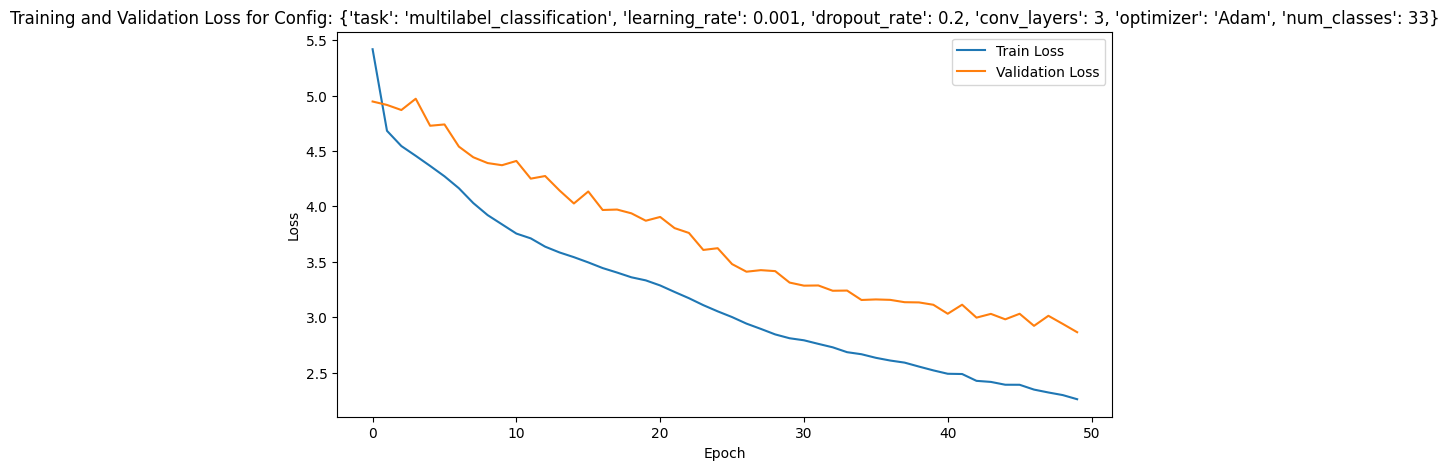

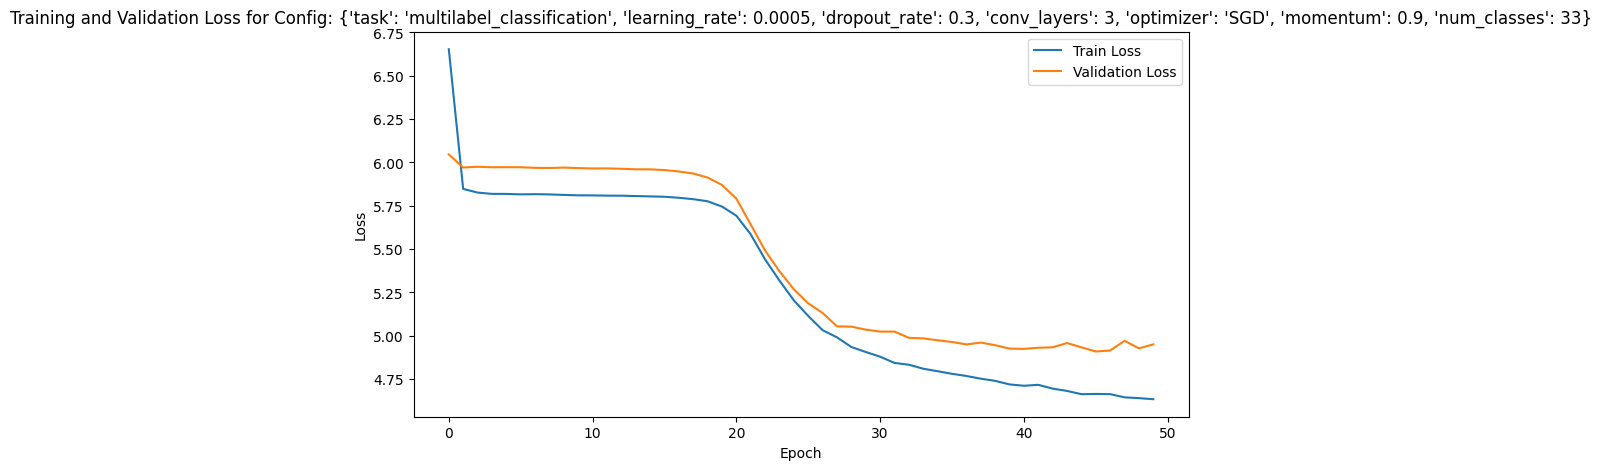

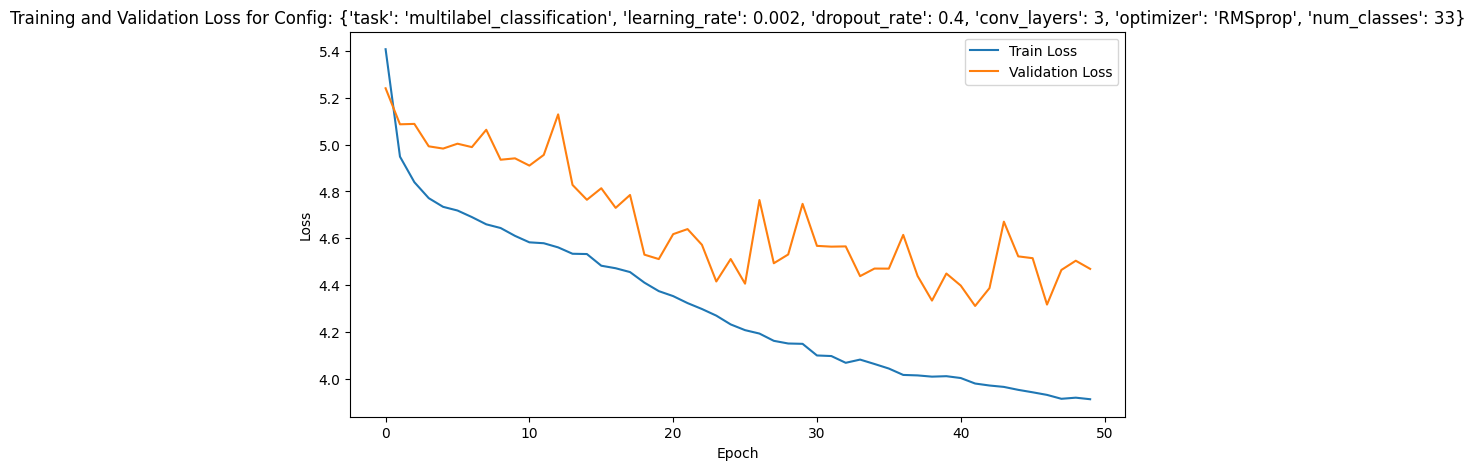

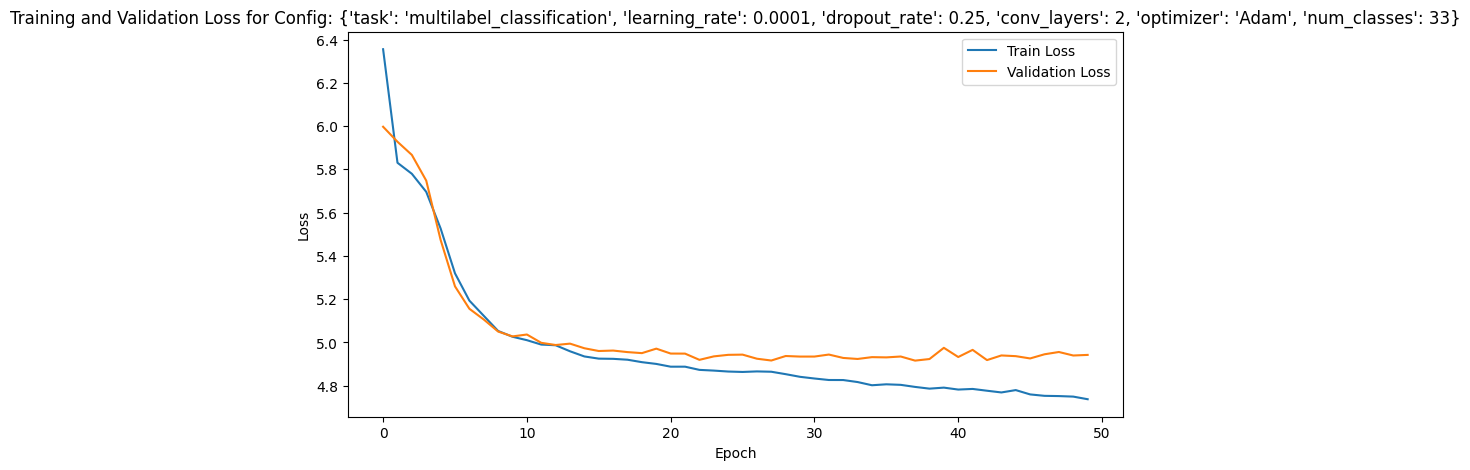

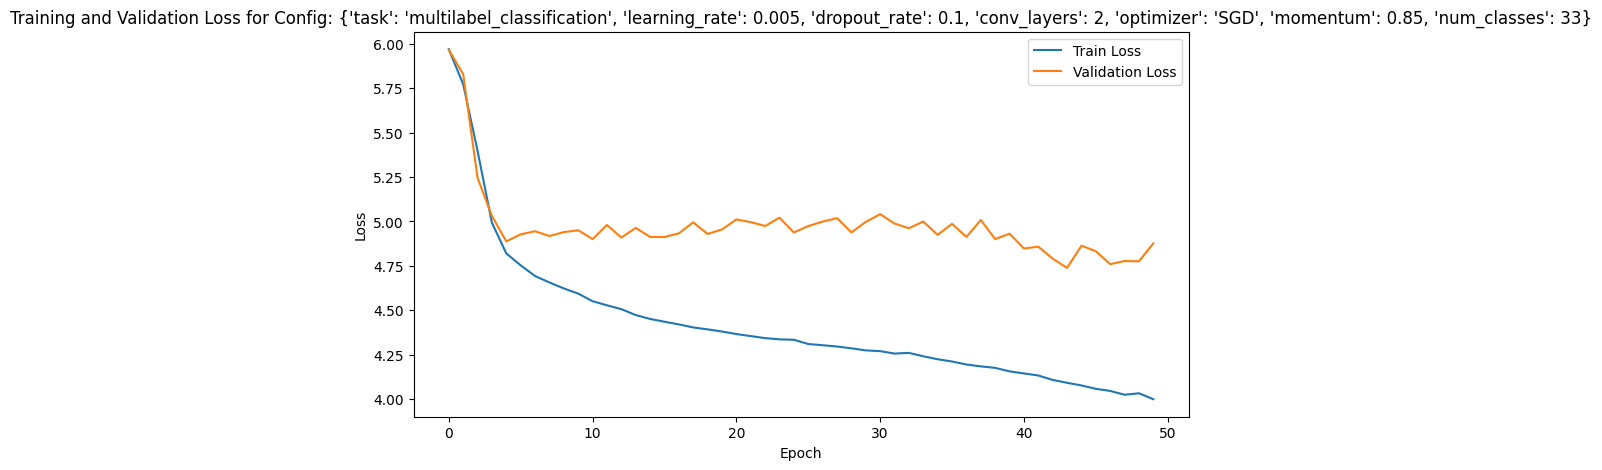

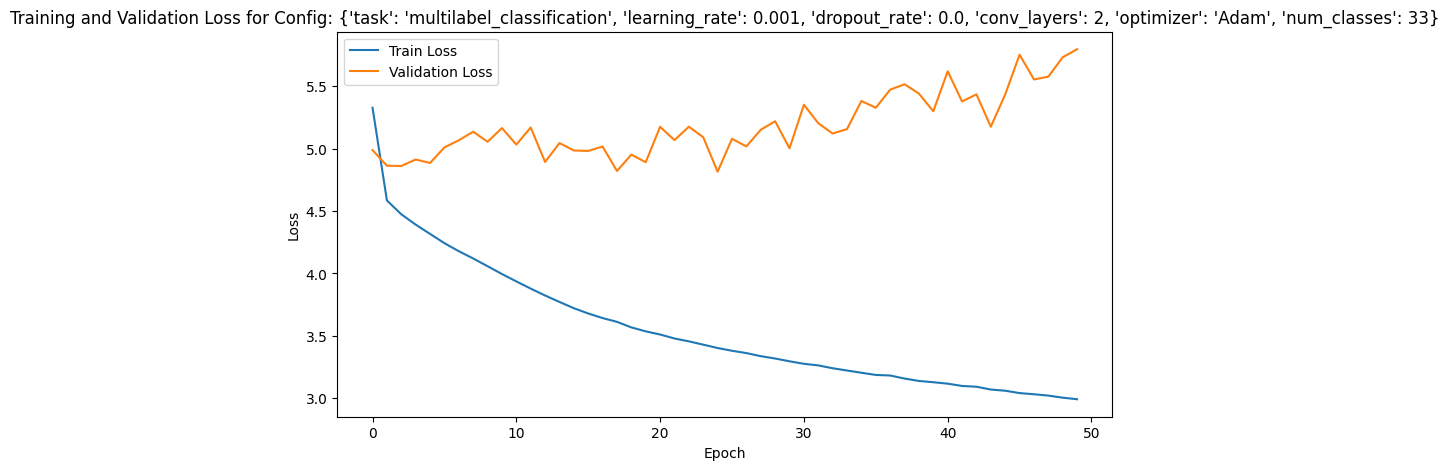

In [272]:
results = tune_multilabel(train_loader_multilabel, val_loader_multilabel, test_loader_multilabel, multilabel_classification_configs, num_epochs=50, device=device)